* input : df_eq.csv
* utilisation d'un jeu de donnée contenant 10% du jeu de données initial
* utilisation d'un jeu de donnée équilibré manuellement en classes cible (50% de refus et 50% d'obtention du crédit bancaire)

* modélisation 2 :données équilibrées manuellement
* création d'une fonction de coût
* Calcul du feature importance et shap d'un modèle

# Introduction

## Problématique

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## Données

* 10 fichiers CSV
* Vous aurez sûrement besoin de joindre les différentes tables entre elles.

## Votre mission

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

Spécifications du dashboard
Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

## Imports et paramétrage

In [1]:
#Importation des librairies utiles pour le projet :

#built in
import statistics
import os, sys, time, random
from collections import Counter

#data
import pandas as pd
import numpy as np

#stats
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

#viz
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image

# modelisation
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import TruncatedSVD 
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

# models

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import cluster
import scipy.cluster.hierarchy as shc
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics.cluster import adjusted_rand_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
import sklearn.metrics
#from functions import *

import shap

C:\Users\ndergham\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option("display.max_rows", None)

In [3]:
#Importation des jeux de données utiles pour le projet :

df1 = pd.read_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/df_eq.csv", index_col=False)
df1 = df1.dropna()

# Comprendre la forme et la structure des données

## Jeux de données

On va regarder rapidement les informations contenues dans les différents jeux de données pour savoir lesquelles sont intéressantes 

In [4]:
df1.head()

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,168319,295108,1,Cash loans,N,Y,0,90000.0,284400.0,13387.5,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,231479,368123,1,Revolving loans,N,N,0,37350.0,202500.0,10125.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,286113,431362,1,Revolving loans,Y,Y,1,202500.0,270000.0,13500.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,250057,389322,1,Cash loans,N,Y,0,90000.0,159264.0,9270.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,301684,449503,1,Cash loans,N,N,1,315000.0,1252278.0,36747.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
df1.shape

(4847, 23)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 23 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   index                                              4847 non-null   int64  
 1   SK_ID_CURR                                         4847 non-null   int64  
 2   TARGET                                             4847 non-null   int64  
 3   NAME_CONTRACT_TYPE                                 4847 non-null   object 
 4   FLAG_OWN_CAR                                       4847 non-null   object 
 5   FLAG_OWN_REALTY                                    4847 non-null   object 
 6   CNT_CHILDREN                                       4847 non-null   int64  
 7   AMT_INCOME_TOTAL                                   4847 non-null   float64
 8   AMT_CREDIT                                         4847 non-null   float64
 9   AMT_ANNU

In [7]:
df1.dtypes

index                                                  int64
SK_ID_CURR                                             int64
TARGET                                                 int64
NAME_CONTRACT_TYPE                                    object
FLAG_OWN_CAR                                          object
FLAG_OWN_REALTY                                       object
CNT_CHILDREN                                           int64
AMT_INCOME_TOTAL                                     float64
AMT_CREDIT                                           float64
AMT_ANNUITY                                          float64
AMT_GOODS_PRICE                                      float64
NAME_EDUCATION_TYPE                                   object
NAME_CONTRACT_TYPE_Cash loans                        float64
NAME_CONTRACT_TYPE_Revolving loans                   float64
FLAG_OWN_CAR_No                                      float64
FLAG_OWN_CAR_Yes                                     float64
FLAG_OWN_REALTY_No      

In [8]:
df1.dtypes.value_counts()

float64    15
int64       4
object      4
dtype: int64

In [9]:
df1.describe()

,index,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
count,4847.000000,4847.000000,4847.000000,4847.000000,4.847000e+03,4.847000e+03,4847.000000,4.847000e+03,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.0,4847.000000,4847.000000,4847.000000,4847.000000
mean,152875.268413,277164.513926,0.500103,0.414483,1.638087e+05,5.727429e+05,26680.212193,5.090060e+05,0.920569,0.079431,0.677945,0.322055,0.308232,0.691768,0.0,0.202187,0.034248,0.015267,0.748298
std,88180.959028,102109.650232,0.500052,0.726297,8.915034e+04,3.702703e+05,13714.678582,3.370387e+05,0.270438,0.270438,0.467312,0.467312,0.461811,0.461811,0.0,0.401672,0.181884,0.122626,0.434036
min,55.000000,100063.000000,0.000000,0.000000,2.700000e+04,4.797000e+04,2722.500000,4.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,76382.500000,188571.500000,0.000000,0.000000,1.125000e+05,2.705332e+05,16627.500000,2.295000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,152663.000000,276938.000000,1.000000,0.000000,1.350000e+05,4.975200e+05,25015.500000,4.500000e+05,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,227403.000000,363409.500000,1.000000,1.000000,2.025000e+05,7.733430e+05,33536.250000,6.750000e+05,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,307481.000000,456225.000000,1.000000,11.000000,1.305000e+06,2.700000e+06,128182.500000,2.700000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


# Définition cible et variables

In [10]:
cols = ["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_CONTRACT_TYPE_Cash loans",
        "NAME_CONTRACT_TYPE_Revolving loans", "FLAG_OWN_CAR_No", "FLAG_OWN_CAR_Yes", "FLAG_OWN_REALTY_No", "FLAG_OWN_REALTY_Yes",
        "NAME_EDUCATION_TYPE_Academic degree", "NAME_EDUCATION_TYPE_Higher education","NAME_EDUCATION_TYPE_Incomplete higher",]
df = df1[cols]
df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher
0,0,90000.0,284400.0,13387.5,225000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,37350.0,202500.0,10125.0,202500.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,202500.0,270000.0,13500.0,270000.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,90000.0,159264.0,9270.0,126000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,315000.0,1252278.0,36747.0,1093500.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
df.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/df_ok_flask.csv", index = False)

In [12]:
cols = ["SK_ID_CURR", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_CONTRACT_TYPE_Cash loans",
        "NAME_CONTRACT_TYPE_Revolving loans", "FLAG_OWN_CAR_No", "FLAG_OWN_CAR_Yes", "FLAG_OWN_REALTY_No", "FLAG_OWN_REALTY_Yes",
        "NAME_EDUCATION_TYPE_Academic degree", "NAME_EDUCATION_TYPE_Higher education","NAME_EDUCATION_TYPE_Incomplete higher",]
df2 = df1[cols]
df2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher
0,295108,0,90000.0,284400.0,13387.5,225000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,368123,0,37350.0,202500.0,10125.0,202500.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,431362,1,202500.0,270000.0,13500.0,270000.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,389322,0,90000.0,159264.0,9270.0,126000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,449503,1,315000.0,1252278.0,36747.0,1093500.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [13]:
y = df1.TARGET

In [14]:
X_train_id, X_test_id, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [15]:
X_test_id = X_test_id.reset_index(drop=True)

In [16]:
X_test_id.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher
0,323836,0,67500.0,137538.0,13734.0,121500.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,131938,1,292500.0,1223010.0,51948.0,1125000.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,251939,0,135000.0,640080.0,31261.5,450000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,180549,0,135000.0,835380.0,40320.0,675000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,326889,0,171000.0,592560.0,35937.0,450000.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
X_test_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SK_ID_CURR                             970 non-null    int64  
 1   CNT_CHILDREN                           970 non-null    int64  
 2   AMT_INCOME_TOTAL                       970 non-null    float64
 3   AMT_CREDIT                             970 non-null    float64
 4   AMT_ANNUITY                            970 non-null    float64
 5   AMT_GOODS_PRICE                        970 non-null    float64
 6   NAME_CONTRACT_TYPE_Cash loans          970 non-null    float64
 7   NAME_CONTRACT_TYPE_Revolving loans     970 non-null    float64
 8   FLAG_OWN_CAR_No                        970 non-null    float64
 9   FLAG_OWN_CAR_Yes                       970 non-null    float64
 10  FLAG_OWN_REALTY_No                     970 non-null    float64
 11  FLAG_O

In [18]:
X_train = X_train_id.drop(['SK_ID_CURR'], axis=1)

In [19]:
X_test = X_test_id.drop(['SK_ID_CURR'], axis=1)

# Modélisation

On va implémenter plusieurs modèles de classification et comparer leur performance pour connaitre la meilleur configuration.

En plus des différents modèles, on va comparer :

- l'usage ou non d'un standard scaler
- l'usage ou non d'un reducteur dimensionnel (PCA, LDA, TruncatedSVD)

## Grid search

On créé un fonction pour afficher les résultats de la grid search triés par **mean_test_score** du plus grand au plus petit.

Le **mean_test_score** est la moyenne des score de test des modèles prédictifs entrainés et testé sur chaque "fold" de la validation croisée.

In [20]:
def resultize(grid, model = "", data ="") : 
    """ """
    
    res = pd.DataFrame(grid.cv_results_)
    res["model"] = model
    cols = [i for i in res.columns if "split" not in i  ]
    
    res
    
    
    return res[cols].sort_values("rank_test_score", ascending=True)

In [21]:
# Liste des scaler à tester

scaler_list = [StandardScaler(),  
               "passthrough"]

In [22]:
# Liste des reducteur dimensionnel à tester

dimensional_reduction_list = [PCA(2),
                              LDA(n_components = 2),
                              TruncatedSVD(n_components = 2),
                             "passthrough"]

## DummyClassifier

In [23]:
y.value_counts(normalize = True)

1    0.500103
0    0.499897
Name: TARGET, dtype: float64

In [24]:
# On crée la grille de paramètres
param_grid = {"scaler" : scaler_list, 
              "reductor" : dimensional_reduction_list,
              "estimator" : [DummyClassifier()]
            
            
             }

In [25]:
# On crée le pipeline

pipe = Pipeline([
     ("scaler", StandardScaler()),
    ("reductor", PCA(2)),
    ("estimator", DummyClassifier())
])
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('reductor', PCA(n_components=2)),
                ('estimator', DummyClassifier())])

In [26]:
dummy = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
dummy.fit(X_train, y_train)
res = resultize(dummy, model = "dummy")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 8 candidates, totalling 80 fits



20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **k

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reductor,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
0,0.033683,0.018583,0.005467,0.005810,DummyClassifier(),PCA(n_components=2),StandardScaler(),"{'estimator': DummyClassifier(), 'reductor': P...",0.5,0.0,1,dummy
1,0.011443,0.001841,0.004380,0.002731,DummyClassifier(),PCA(n_components=2),passthrough,"{'estimator': DummyClassifier(), 'reductor': P...",0.5,0.0,1,dummy
4,0.015626,0.006987,0.003126,0.006251,DummyClassifier(),TruncatedSVD(),StandardScaler(),"{'estimator': DummyClassifier(), 'reductor': T...",0.5,0.0,1,dummy
5,0.010937,0.007160,0.004688,0.007160,DummyClassifier(),TruncatedSVD(),passthrough,"{'estimator': DummyClassifier(), 'reductor': T...",0.5,0.0,1,dummy
6,0.007812,0.007812,0.004687,0.007159,DummyClassifier(),passthrough,StandardScaler(),"{'estimator': DummyClassifier(), 'reductor': '...",0.5,0.0,1,dummy
7,0.003126,0.006251,0.001563,0.004688,DummyClassifier(),passthrough,passthrough,"{'estimator': DummyClassifier(), 'reductor': '...",0.5,0.0,1,dummy
2,0.007814,0.010484,0.000000,0.000000,DummyClassifier(),LinearDiscriminantAnalysis(n_components=2),StandardScaler(),"{'estimator': DummyClassifier(), 'reductor': L...",NaN,NaN,7,dummy
3,0.003125,0.006249,0.000000,0.000000,DummyClassifier(),LinearDiscriminantAnalysis(n_components=2),passthrough,"{'estimator': DummyClassifier(), 'reductor': L...",NaN,NaN,8,dummy


### Indicateurs

In [27]:
y_pred_dummy = dummy.predict(X_test)

In [28]:
a0 = confusion_matrix(y_test, y_pred_dummy)
a0

array([[477,   0],
       [493,   0]], dtype=int64)

In [29]:
b0 = accuracy_score(y_test, y_pred_dummy)
b0

0.4917525773195876

In [30]:
c0 = f1_score(y_test, y_pred_dummy)
c0

0.0

In [31]:
d0 = recall_score(y_test, y_pred_dummy)
d0

0.0

In [32]:
e0 = precision_score(y_test, y_pred_dummy)
e0

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


0.0

In [33]:
f0 = roc_auc_score(y_test, y_pred_dummy)
f0

0.5

## Random Forest

In [34]:
# On crée la grille de paramètres

param_grid = {"scaler" : scaler_list, 
              "reductor" : dimensional_reduction_list,
              "estimator" : [RandomForestClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 20, n_estimators = 500)],
              
            
             }

In [35]:
# On crée le pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reductor", PCA(2)),
    ("estimator", RandomForestClassifier(min_samples_split = 5, min_samples_leaf = 1, max_depth = 20, n_estimators = 500))
])
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('reductor', PCA(n_components=2)),
                ('estimator',
                 RandomForestClassifier(max_depth=20, min_samples_split=5,
                                        n_estimators=500))])

In [36]:
R_F = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
R_F.fit(X_train, y_train)
res = resultize(R_F, model = "Random Forest")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 8 candidates, totalling 80 fits



20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **k

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reductor,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
6,4.847868,0.515087,0.187286,0.022663,"RandomForestClassifier(max_depth=20, min_sampl...",passthrough,StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.591524,0.017561,1,Random Forest
7,4.103611,0.514405,0.143885,0.041254,"RandomForestClassifier(max_depth=20, min_sampl...",passthrough,passthrough,{'estimator': RandomForestClassifier(max_depth...,0.591088,0.018375,2,Random Forest
5,5.698763,0.366999,0.206724,0.034075,"RandomForestClassifier(max_depth=20, min_sampl...",TruncatedSVD(),passthrough,{'estimator': RandomForestClassifier(max_depth...,0.547271,0.030053,3,Random Forest
0,4.703016,0.369297,0.165448,0.023987,"RandomForestClassifier(max_depth=20, min_sampl...",PCA(n_components=2),StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.544869,0.035352,4,Random Forest
4,5.602150,0.438621,0.186234,0.018809,"RandomForestClassifier(max_depth=20, min_sampl...",TruncatedSVD(),StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,0.544724,0.034844,5,Random Forest
1,5.521983,0.355294,0.201348,0.028881,"RandomForestClassifier(max_depth=20, min_sampl...",PCA(n_components=2),passthrough,{'estimator': RandomForestClassifier(max_depth...,0.535998,0.033191,6,Random Forest
2,0.014066,0.004689,0.000000,0.000000,"RandomForestClassifier(max_depth=20, min_sampl...",LinearDiscriminantAnalysis(n_components=2),StandardScaler(),{'estimator': RandomForestClassifier(max_depth...,NaN,NaN,7,Random Forest
3,0.006382,0.007825,0.000000,0.000000,"RandomForestClassifier(max_depth=20, min_sampl...",LinearDiscriminantAnalysis(n_components=2),passthrough,{'estimator': RandomForestClassifier(max_depth...,NaN,NaN,8,Random Forest


In [37]:
y_pred_rf = R_F.predict(X_test)

In [38]:
a1 = confusion_matrix(y_test, y_pred_rf)
a1

array([[280, 197],
       [213, 280]], dtype=int64)

In [39]:
b1 = accuracy_score(y_test, y_pred_rf)
b1

0.5773195876288659

In [40]:
c1 = f1_score(y_test, y_pred_rf)
c1

0.577319587628866

In [41]:
d1 = recall_score(y_test, y_pred_rf)
d1

0.5679513184584178

In [42]:
e1 = precision_score(y_test, y_pred_rf)
e1

0.5870020964360587

In [43]:
f1 = roc_auc_score(y_test, y_pred_rf)
f1

0.5774767074472382

## K-NN

In [44]:
# On crée la grille de paramètres
param_grid = {"scaler" : scaler_list, 
              "reductor" : dimensional_reduction_list,
              "estimator" : [neighbors.KNeighborsClassifier(n_neighbors=3)]
            
            
             }

In [45]:
# On crée le pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reductor", PCA(200)),
    ("estimator", neighbors.KNeighborsClassifier(n_neighbors=3))
])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('reductor', PCA(n_components=200)),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

In [46]:
K_NN = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
K_NN.fit(X_train, y_train)
res = resultize(K_NN, model = "K-NN")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 8 candidates, totalling 80 fits



20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **k

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reductor,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
6,0.030120,0.004462,0.028041,0.007286,KNeighborsClassifier(n_neighbors=3),passthrough,StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.543575,0.021723,1,K-NN
7,0.025568,0.005744,0.009979,0.002699,KNeighborsClassifier(n_neighbors=3),passthrough,passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.533780,0.030077,2,K-NN
4,0.027769,0.009498,0.016244,0.009512,KNeighborsClassifier(n_neighbors=3),TruncatedSVD(),StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.532468,0.013911,3,K-NN
0,0.021923,0.004270,0.006419,0.003896,KNeighborsClassifier(n_neighbors=3),PCA(n_components=2),StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,0.532403,0.013562,4,K-NN
5,0.019466,0.003861,0.008475,0.004369,KNeighborsClassifier(n_neighbors=3),TruncatedSVD(),passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.528951,0.026177,5,K-NN
1,0.017607,0.004346,0.008138,0.002515,KNeighborsClassifier(n_neighbors=3),PCA(n_components=2),passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,0.524764,0.026350,6,K-NN
2,0.011136,0.003433,0.000000,0.000000,KNeighborsClassifier(n_neighbors=3),LinearDiscriminantAnalysis(n_components=2),StandardScaler(),{'estimator': KNeighborsClassifier(n_neighbors...,NaN,NaN,7,K-NN
3,0.005842,0.001258,0.000000,0.000000,KNeighborsClassifier(n_neighbors=3),LinearDiscriminantAnalysis(n_components=2),passthrough,{'estimator': KNeighborsClassifier(n_neighbors...,NaN,NaN,8,K-NN


In [47]:
y_pred_knn = K_NN.predict(X_test)

In [48]:
a2 = confusion_matrix(y_test, y_pred_knn)
a2

array([[247, 230],
       [208, 285]], dtype=int64)

In [49]:
b2 = accuracy_score(y_test, y_pred_knn)
b2

0.5484536082474227

In [50]:
c2 = f1_score(y_test, y_pred_knn)
c2

0.5654761904761905

In [51]:
d2 =recall_score(y_test, y_pred_knn)
d2

0.5780933062880325

In [52]:
e2 = precision_score(y_test, y_pred_knn)
e2

0.5533980582524272

In [53]:
f2 = roc_auc_score(y_test, y_pred_knn)
f2

0.5479565063934921

* https://datacorner.fr/model-class-evaluatation/
* https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308256-evaluez-un-algorithme-de-classification-qui-retourne-des-valeurs-binaires

## regression logistique

In [54]:
# On crée la grille de paramètres

param_grid = {"scaler" : scaler_list, 
              "reductor" : dimensional_reduction_list,
              "estimator" : [LogisticRegression()]
              
            
             }

In [55]:
# On crée le pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reductor", PCA(200)),
    ("estimator", LogisticRegression())
])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('reductor', PCA(n_components=200)),
                ('estimator', LogisticRegression())])

In [56]:
R_L = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
R_L.fit(X_train, y_train)
res = resultize(R_L, model = "Regression logistique")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 8 candidates, totalling 80 fits



20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **k

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reductor,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
6,0.022602,0.001019,0.004898,0.000700,LogisticRegression(),passthrough,StandardScaler(),"{'estimator': LogisticRegression(), 'reductor'...",0.594778,0.024630,1,Regression logistique
7,0.022099,0.005107,0.004816,0.003879,LogisticRegression(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'reductor'...",0.572041,0.016872,2,Regression logistique
0,0.020101,0.001044,0.004799,0.000748,LogisticRegression(),PCA(n_components=2),StandardScaler(),"{'estimator': LogisticRegression(), 'reductor'...",0.549498,0.020165,3,Regression logistique
4,0.022571,0.006373,0.004800,0.000749,LogisticRegression(),TruncatedSVD(),StandardScaler(),"{'estimator': LogisticRegression(), 'reductor'...",0.549498,0.020165,3,Regression logistique
1,0.020099,0.002119,0.005101,0.002118,LogisticRegression(),PCA(n_components=2),passthrough,"{'estimator': LogisticRegression(), 'reductor'...",0.537120,0.031638,5,Regression logistique
5,0.022800,0.003944,0.004900,0.000299,LogisticRegression(),TruncatedSVD(),passthrough,"{'estimator': LogisticRegression(), 'reductor'...",0.526851,0.030867,6,Regression logistique
2,0.009400,0.000661,0.000000,0.000000,LogisticRegression(),LinearDiscriminantAnalysis(n_components=2),StandardScaler(),"{'estimator': LogisticRegression(), 'reductor'...",NaN,NaN,7,Regression logistique
3,0.004999,0.000447,0.000000,0.000000,LogisticRegression(),LinearDiscriminantAnalysis(n_components=2),passthrough,"{'estimator': LogisticRegression(), 'reductor'...",NaN,NaN,8,Regression logistique


In [57]:
y_pred_rl = R_L.predict(X_test)

In [58]:
a3 = confusion_matrix(y_test, y_pred_rl)
a3

array([[230, 247],
       [178, 315]], dtype=int64)

In [59]:
b3 = accuracy_score(y_test, y_pred_rl)
b3

0.5618556701030928

In [60]:
c3 = f1_score(y_test, y_pred_rl)
c3

0.5971563981042655

In [61]:
d3 = recall_score(y_test, y_pred_rl)
d3

0.6389452332657201

In [62]:
e3 = precision_score(y_test, y_pred_rl)
e3

0.5604982206405694

In [63]:
f3 = roc_auc_score(y_test, y_pred_rl)
f3

0.5605627633833841

## XG Boost

In [64]:
# On crée la grille de paramètres

param_grid = {"scaler" : scaler_list, 
              "reductor" : dimensional_reduction_list,
              "estimator" : [xgb.XGBClassifier()],
              
            
             }

In [65]:
# On crée le pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reductor", PCA(200)),
    ("estimator", xgb.XGBClassifier())
])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('reductor', PCA(n_components=200)),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               gamma=None, gpu_id=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

In [66]:
X_G = GridSearchCV(pipe, param_grid, scoring = "roc_auc", cv = 10, verbose=3 , n_jobs=-1)
X_G.fit(X_train, y_train)
res = resultize(X_G, model = "XGBOOST")
# ALL_RES = pd.concat([ALL_RES, res.head()], axis=0, ignore_index=True)
res

Fitting 10 folds for each of 8 candidates, totalling 80 fits



20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\ndergham\Anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **k

[14:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reductor,param_scaler,params,mean_test_score,std_test_score,rank_test_score,model
6,1.392609,0.049345,0.014195,0.004748,"XGBClassifier(base_score=None, booster=None, c...",passthrough,StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.596849,0.022478,1,XGBOOST
7,1.114603,0.255547,0.007814,0.007814,"XGBClassifier(base_score=None, booster=None, c...",passthrough,passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.596825,0.022420,2,XGBOOST
0,1.500531,0.105084,0.020624,0.011503,"XGBClassifier(base_score=None, booster=None, c...",PCA(n_components=2),StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.552686,0.019711,3,XGBOOST
4,1.274078,0.060647,0.014327,0.009153,"XGBClassifier(base_score=None, booster=None, c...",TruncatedSVD(),StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",0.552686,0.019711,3,XGBOOST
5,1.442719,0.044857,0.011071,0.007258,"XGBClassifier(base_score=None, booster=None, c...",TruncatedSVD(),passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.542541,0.029141,5,XGBOOST
1,1.301930,0.054538,0.013710,0.004690,"XGBClassifier(base_score=None, booster=None, c...",PCA(n_components=2),passthrough,"{'estimator': XGBClassifier(base_score=None, b...",0.534167,0.036309,6,XGBOOST
2,0.009375,0.007654,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",LinearDiscriminantAnalysis(n_components=2),StandardScaler(),"{'estimator': XGBClassifier(base_score=None, b...",NaN,NaN,7,XGBOOST
3,0.004818,0.007368,0.000000,0.000000,"XGBClassifier(base_score=None, booster=None, c...",LinearDiscriminantAnalysis(n_components=2),passthrough,"{'estimator': XGBClassifier(base_score=None, b...",NaN,NaN,8,XGBOOST


In [67]:
y_pred_xg = X_G.predict(X_test)

In [68]:
a4 = confusion_matrix(y_test, y_pred_xg)
a4

array([[266, 211],
       [219, 274]], dtype=int64)

In [69]:
b4 = accuracy_score(y_test, y_pred_xg)

In [70]:
c4 =f1_score(y_test, y_pred_xg)
c4

0.5603271983640081

In [71]:
d4 = recall_score(y_test, y_pred_xg)
d4

0.5557809330628803

In [72]:
e4 = precision_score(y_test, y_pred_xg)
e4

0.5649484536082474

In [73]:
f4 = roc_auc_score(y_test, y_pred_xg)
f4

0.556716462338568

# Récapitulatif et conclusions

In [74]:
resultats = pd.DataFrame({
                        'Dummy': [a0, b0, c0, d0, e0, f0], 
                          'Random Forest': [a1, b1, c1, d1, e1, f1],
                         'K-NN': [a2, b2, c2, d2, e2, f2],
                         'Logistic regression': [a3, b3, c3, d3, e3, f3],
                        'XG-Boost': [a4, b4, c4, d4, e4, f4]},
                         index = ['Matrice de confusion', 'Accuracy', "F1", "Recall", "Precision", "ROC AUC"])

In [75]:
resultats

,Dummy,Random Forest,K-NN,Logistic regression,XG-Boost
Matrice de confusion,"[[477, 0], [493, 0]]","[[280, 197], [213, 280]]","[[247, 230], [208, 285]]","[[230, 247], [178, 315]]","[[266, 211], [219, 274]]"
Accuracy,0.491753,0.57732,0.548454,0.561856,0.556701
F1,0.0,0.57732,0.565476,0.597156,0.560327
Recall,0.0,0.567951,0.578093,0.638945,0.555781
Precision,0.0,0.587002,0.553398,0.560498,0.564948
ROC AUC,0.5,0.577477,0.547957,0.560563,0.556716


La regression logistique permet d'obtenir les meilleurs résultats pour la modélisation de données. On choisi comme indicateur de choix ROC AUC.

# Fonction de décision / de coût

In [76]:
def fonction_decision (X):
    
    # extract amount credit
    #X["profit"] = X["AMT_CREDIT"] * rate
    
    
    # compute profit and lost 
   
    if X["pred"] == 1 :
         return 0
    elif X["y_true"] == 0 and X["pred"] == 0:
         return X["profit"]

    return -X["AMT_CREDIT"]

## DummyClasifier

In [77]:
X_dummy = pd.DataFrame(y_pred_dummy, columns = ["pred"])

In [78]:
X_dummy["y_true"] = y_test.reset_index(drop = True)

In [79]:
X_dummy["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [80]:
X_dummy["profit"] = X_test["AMT_CREDIT"] * 0.04
X_dummy.head()

,pred,y_true,AMT_CREDIT,profit
0,0,0,137538.0,5501.52
1,0,0,1223010.0,48920.40
2,0,1,640080.0,25603.20
3,0,1,835380.0,33415.20
4,0,1,592560.0,23702.40


In [81]:
PNL = []

for i in X_dummy.index :
    result = fonction_decision(X_dummy.loc[i])
    PNL.append(result)

In [82]:
PNL

[5501.52,
 48920.4,
 -640080.0,
 -835380.0,
 -592560.0,
 -545040.0,
 -1237500.0,
 -1494486.0,
 -755190.0,
 -579942.0,
 9000.0,
 -90000.0,
 -640080.0,
 -225000.0,
 -269550.0,
 -754740.0,
 40276.8,
 14932.44,
 12208.86,
 30409.02,
 -745119.0,
 6880.860000000001,
 3184.2000000000003,
 -409653.0,
 -263686.5,
 -900000.0,
 52876.08,
 -292500.0,
 -284400.0,
 -225000.0,
 11213.28,
 14663.52,
 -521280.0,
 -675000.0,
 4577.22,
 38948.4,
 -1096924.5,
 50346.0,
 -331920.0,
 -490536.0,
 -129384.0,
 -247500.0,
 4075.2000000000003,
 40276.8,
 33415.2,
 16351.2,
 -521280.0,
 -808650.0,
 -450000.0,
 51740.1,
 9594.0,
 55175.04,
 42463.98,
 -1762110.0,
 -112500.0,
 -1049746.5,
 -477621.0,
 23613.48,
 -457717.5,
 44280.0,
 -1223010.0,
 -454500.0,
 9000.0,
 -544491.0,
 -942300.0,
 -1317357.0,
 -254700.0,
 -313438.5,
 -1113840.0,
 -417024.0,
 -161730.0,
 -1006920.0,
 10782.0,
 -180000.0,
 18000.0,
 -545040.0,
 -523237.5,
 13569.66,
 11851.2,
 30328.56,
 40276.8,
 45180.0,
 54000.0,
 8625.6,
 88200.0,
 -172

In [83]:
cout_dummy = sum(PNL)
cout_dummy

-269038222.56000024

## Random Forest

In [84]:
X_rf = pd.DataFrame(y_pred_rf, columns = ["pred"])

In [85]:
X_rf["y_true"] = y_test.reset_index(drop = True)

In [86]:
X_rf["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [87]:
X_rf["profit"] = X_test["AMT_CREDIT"] * 0.04
X_rf.head()

,pred,y_true,AMT_CREDIT,profit
0,0,0,137538.0,5501.52
1,0,0,1223010.0,48920.40
2,1,1,640080.0,25603.20
3,1,1,835380.0,33415.20
4,1,1,592560.0,23702.40


In [88]:
PNL = []

for i in X_rf.index :
    result = fonction_decision(X_rf.loc[i])
    PNL.append(result)

In [89]:
PNL

[5501.52,
 48920.4,
 0,
 0,
 0,
 0,
 0,
 -1494486.0,
 0,
 -579942.0,
 9000.0,
 -90000.0,
 0,
 0,
 0,
 -754740.0,
 40276.8,
 0,
 12208.86,
 30409.02,
 0,
 6880.860000000001,
 3184.2000000000003,
 -409653.0,
 -263686.5,
 -900000.0,
 0,
 0,
 -284400.0,
 0,
 0,
 14663.52,
 0,
 0,
 4577.22,
 0,
 -1096924.5,
 0,
 0,
 0,
 0,
 -247500.0,
 4075.2000000000003,
 40276.8,
 0,
 0,
 -521280.0,
 0,
 0,
 51740.1,
 9594.0,
 55175.04,
 42463.98,
 -1762110.0,
 -112500.0,
 0,
 0,
 0,
 0,
 44280.0,
 -1223010.0,
 -454500.0,
 0,
 -544491.0,
 0,
 -1317357.0,
 -254700.0,
 0,
 -1113840.0,
 0,
 0,
 -1006920.0,
 0,
 -180000.0,
 0,
 0,
 0,
 0,
 0,
 30328.56,
 40276.8,
 45180.0,
 54000.0,
 8625.6,
 88200.0,
 0,
 -970380.0,
 -549000.0,
 -1615968.0,
 0,
 10782.0,
 36975.78,
 0,
 0,
 0,
 0,
 -1096020.0,
 -562500.0,
 19259.82,
 40114.8,
 -770292.0,
 0,
 51534.0,
 0,
 37692.0,
 0,
 0,
 0,
 0,
 0,
 0,
 -654498.0,
 -753840.0,
 12208.86,
 0,
 27000.0,
 -495000.0,
 0,
 0,
 0,
 21600.0,
 23720.4,
 29524.32,
 0,
 38948.4,
 10

In [90]:
cout_RF = sum(PNL)
cout_RF

-133015199.04000005

## K-NN

In [91]:
X_knn = pd.DataFrame(y_pred_knn, columns = ["pred"])

In [92]:
X_knn["y_true"] = y_test.reset_index(drop = True)

In [93]:
X_knn["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [94]:
X_knn["profit"] = X_test["AMT_CREDIT"] * 0.04
X_knn.head()

,pred,y_true,AMT_CREDIT,profit
0,0,0,137538.0,5501.52
1,0,0,1223010.0,48920.40
2,1,1,640080.0,25603.20
3,1,1,835380.0,33415.20
4,1,1,592560.0,23702.40


In [95]:
PNL = []

for i in X_knn.index :
    result = fonction_decision(X_knn.loc[i])
    PNL.append(result)

In [96]:
PNL

[5501.52,
 48920.4,
 0,
 0,
 0,
 0,
 -1237500.0,
 -1494486.0,
 0,
 -579942.0,
 9000.0,
 -90000.0,
 0,
 -225000.0,
 -269550.0,
 0,
 40276.8,
 0,
 12208.86,
 0,
 0,
 0,
 0,
 -409653.0,
 0,
 -900000.0,
 0,
 0,
 -284400.0,
 0,
 0,
 14663.52,
 0,
 0,
 4577.22,
 0,
 -1096924.5,
 0,
 0,
 -490536.0,
 0,
 -247500.0,
 4075.2000000000003,
 40276.8,
 33415.2,
 0,
 -521280.0,
 0,
 -450000.0,
 51740.1,
 0,
 0,
 0,
 0,
 0,
 0,
 -477621.0,
 0,
 0,
 44280.0,
 0,
 -454500.0,
 0,
 -544491.0,
 0,
 -1317357.0,
 -254700.0,
 0,
 -1113840.0,
 0,
 0,
 -1006920.0,
 10782.0,
 0,
 0,
 -545040.0,
 0,
 0,
 0,
 30328.56,
 40276.8,
 0,
 54000.0,
 8625.6,
 88200.0,
 0,
 -970380.0,
 -549000.0,
 0,
 0,
 10782.0,
 0,
 0,
 0,
 0,
 -512064.0,
 -1096020.0,
 0,
 0,
 40114.8,
 -770292.0,
 0,
 51534.0,
 0,
 37692.0,
 0,
 0,
 -270000.0,
 0,
 0,
 0,
 -654498.0,
 -753840.0,
 12208.86,
 0,
 27000.0,
 -495000.0,
 0,
 18000.0,
 37692.0,
 0,
 23720.4,
 0,
 0,
 38948.4,
 10800.0,
 -1288350.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 30960.0,
 417

In [97]:
cout_knn = sum(PNL)
cout_knn

-123501699.90000004

## Regression Logistique

In [98]:
X_rl = pd.DataFrame(y_pred_rl, columns = ["pred"])

In [99]:
X_rl["y_true"] = y_test.reset_index(drop = True)

In [100]:
X_rl["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [101]:
X_rl["profit"] = X_test["AMT_CREDIT"] * 0.04
X_rl.head()

,pred,y_true,AMT_CREDIT,profit
0,1,0,137538.0,5501.52
1,0,0,1223010.0,48920.40
2,1,1,640080.0,25603.20
3,1,1,835380.0,33415.20
4,1,1,592560.0,23702.40


In [102]:
PNL = []

for i in X_rl.index :
    result = fonction_decision(X_rl.loc[i])
    PNL.append(result)

In [103]:
PNL

[0,
 48920.4,
 0,
 0,
 0,
 0,
 -1237500.0,
 -1494486.0,
 -755190.0,
 0,
 0,
 0,
 0,
 0,
 0,
 -754740.0,
 40276.8,
 0,
 0,
 0,
 -745119.0,
 0,
 0,
 0,
 0,
 -900000.0,
 0,
 0,
 0,
 -225000.0,
 0,
 0,
 0,
 -675000.0,
 0,
 0,
 0,
 50346.0,
 0,
 0,
 0,
 -247500.0,
 0,
 0,
 0,
 0,
 -521280.0,
 0,
 -450000.0,
 51740.1,
 9594.0,
 0,
 42463.98,
 -1762110.0,
 -112500.0,
 -1049746.5,
 0,
 0,
 0,
 44280.0,
 -1223010.0,
 -454500.0,
 0,
 0,
 0,
 -1317357.0,
 -254700.0,
 0,
 0,
 0,
 0,
 -1006920.0,
 0,
 -180000.0,
 18000.0,
 0,
 0,
 0,
 0,
 0,
 40276.8,
 45180.0,
 54000.0,
 0,
 88200.0,
 0,
 0,
 -549000.0,
 0,
 0,
 0,
 0,
 0,
 0,
 9907.02,
 -512064.0,
 0,
 0,
 0,
 40114.8,
 -770292.0,
 0,
 51534.0,
 0,
 37692.0,
 -283500.0,
 18000.0,
 -270000.0,
 0,
 0,
 54419.94,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 18000.0,
 0,
 21600.0,
 0,
 0,
 0,
 38948.4,
 10800.0,
 -1288350.0,
 0,
 0,
 0,
 45762.12,
 -781920.0,
 27000.0,
 0,
 30960.0,
 4170.24,
 0,
 16200.0,
 0,
 10800.0,
 0,
 0,
 -1185120.0,
 0,
 0,
 0,
 32400.0,
 37

In [104]:
cout_rl = sum(PNL)
cout_rl

-116290029.24000001

## XG

In [105]:
X_fonction = pd.DataFrame(y_pred_xg, columns = ["pred"])

In [106]:
X_fonction["y_true"] = y_test.reset_index(drop = True)

In [107]:
X_fonction["AMT_CREDIT"] = X_test.AMT_CREDIT.reset_index(drop=True)

In [108]:
X_fonction["profit"] = X_test["AMT_CREDIT"] * 0.04
X_fonction.head()

,pred,y_true,AMT_CREDIT,profit
0,1,0,137538.0,5501.52
1,0,0,1223010.0,48920.40
2,1,1,640080.0,25603.20
3,1,1,835380.0,33415.20
4,1,1,592560.0,23702.40


In [109]:
PNL = []

for i in X_fonction.index :
    result = fonction_decision(X_fonction.loc[i])
    PNL.append(result)

In [110]:
PNL

[0,
 48920.4,
 0,
 0,
 0,
 0,
 -1237500.0,
 -1494486.0,
 0,
 -579942.0,
 9000.0,
 0,
 0,
 -225000.0,
 0,
 -754740.0,
 40276.8,
 0,
 12208.86,
 30409.02,
 -745119.0,
 6880.860000000001,
 0,
 0,
 0,
 -900000.0,
 0,
 0,
 0,
 0,
 0,
 14663.52,
 0,
 0,
 4577.22,
 0,
 -1096924.5,
 50346.0,
 -331920.0,
 0,
 -129384.0,
 -247500.0,
 4075.2000000000003,
 0,
 0,
 0,
 -521280.0,
 0,
 0,
 0,
 9594.0,
 55175.04,
 42463.98,
 -1762110.0,
 -112500.0,
 -1049746.5,
 0,
 0,
 0,
 44280.0,
 -1223010.0,
 -454500.0,
 0,
 -544491.0,
 0,
 -1317357.0,
 0,
 0,
 -1113840.0,
 0,
 0,
 -1006920.0,
 0,
 0,
 0,
 0,
 0,
 13569.66,
 0,
 0,
 0,
 45180.0,
 54000.0,
 0,
 88200.0,
 0,
 -970380.0,
 -549000.0,
 -1615968.0,
 0,
 10782.0,
 36975.78,
 0,
 0,
 9907.02,
 0,
 -1096020.0,
 0,
 19259.82,
 40114.8,
 -770292.0,
 0,
 0,
 0,
 37692.0,
 0,
 0,
 0,
 -472500.0,
 0,
 54419.94,
 0,
 -753840.0,
 12208.86,
 0,
 27000.0,
 -495000.0,
 0,
 18000.0,
 37692.0,
 0,
 0,
 29524.32,
 0,
 0,
 10800.0,
 -1288350.0,
 0,
 0,
 0,
 0,
 -781920

In [111]:
cout_xg = sum(PNL)
cout_xg

-135700067.33999997

# Récapitulatif des coûts des modèles

In [112]:
resultats_modeles = pd.DataFrame({
                        'Dummy': [cout_dummy], 
                          'Random Forest': [cout_RF],
                         'K-NN': [cout_knn],
                         'Logistic regression': [cout_rl],
                        'XG-Boost': [cout_xg]},
                         index = ["Profit"])
resultats_modeles

,Dummy,Random Forest,K-NN,Logistic regression,XG-Boost
Profit,-2.690382e+08,-1.330152e+08,-123501699.9,-1.162900e+08,-1.357001e+08


In [113]:
import pickle

In [114]:
with open("X_G.pk","wb") as f:
    pickle.dump(X_G, f)

In [115]:
X_G

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reductor', PCA(n_components=200)),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      ma...
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None,
                                                     scale_pos_weight=None,
                                                     subsample=None,
                                                     tree_method=None,
                                                     validate_parameters=None,
                                                     verbosity=None)],
                         'reductor': [PCA(n_components=2),
                                      LinearDiscriminantAnalysis(n_components=2),
                                      TruncatedSVD(), 'passthrough'],
                         'scaler': [StandardScaler(), 'passthrough']},
             scoring='roc_auc', verbose=3)

In [116]:
with open("X_G.pk","rb") as f:
    model = pickle.load(f)

In [117]:
model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reductor', PCA(n_components=200)),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      ma...
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None,
                                                     scale_pos_weight=None,
                                                     subsample=None,
                                                     tree_method=None,
                                                     validate_parameters=None,
                                                     verbosity=None)],
                         'reductor': [PCA(n_components=2),
                                      LinearDiscriminantAnalysis(n_components=2),
                                      TruncatedSVD(), 'passthrough'],
                         'scaler': [StandardScaler(), 'passthrough']},
             scoring='roc_auc', verbose=3)

# Shap

In [118]:
from xgboost import XGBClassifier
XGB = XGBClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
XGB.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[14:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
with open("XGB.pk","wb") as f:
    pickle.dump(XGB, f)

XGB

with open("XGB.pk","rb") as f:
    model2 = pickle.load(f)

model2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
preds = XGB.predict(X_test)
preds

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,

## Shap

In [121]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGB)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [122]:
df_shap_values = pd.DataFrame(shap_values, columns = X_test.columns)
df_shap_values

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher
0,-0.031628,-0.226837,-0.724327,-0.333426,1.194368,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0
1,0.073337,-0.147986,0.876499,-0.023938,-1.319278,0.008871,0.0,-0.174608,0.0,-0.043404,0.0,0.0,-0.389126,0.0
2,-0.031628,-0.077924,0.328170,0.272331,0.333714,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0
3,-0.031628,-0.077924,0.405563,0.209085,-0.519022,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0
4,-0.031628,0.239119,0.328170,0.209085,0.333714,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0
5,-0.031628,0.067562,0.328170,0.098099,0.333714,0.008871,0.0,0.083257,0.0,-0.043404,0.0,0.0,0.101778,0.0
6,-0.031628,-0.147986,0.876499,0.209085,-1.245938,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0
7,0.073337,-0.077924,0.324136,0.209085,-1.245938,0.008871,0.0,0.083257,0.0,-0.043404,0.0,0.0,0.101778,0.0
8,0.073337,0.067562,0.328170,0.209085,-0.519022,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,-0.389126,0.0
9,-0.031628,0.067562,0.328170,0.209085,-0.519022,0.008871,0.0,-0.174608,0.0,0.019059,0.0,0.0,0.101778,0.0


In [123]:
 df_shap_values["SK_ID_CURR"] = X_test_id["SK_ID_CURR"]

In [124]:
df_shap_values.shape

(970, 15)

In [125]:
df_shap_values.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_OWN_CAR_No,FLAG_OWN_CAR_Yes,FLAG_OWN_REALTY_No,FLAG_OWN_REALTY_Yes,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,SK_ID_CURR
0,-0.031628,-0.226837,-0.724327,-0.333426,1.194368,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0,323836
1,0.073337,-0.147986,0.876499,-0.023938,-1.319278,0.008871,0.0,-0.174608,0.0,-0.043404,0.0,0.0,-0.389126,0.0,131938
2,-0.031628,-0.077924,0.328170,0.272331,0.333714,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0,251939
3,-0.031628,-0.077924,0.405563,0.209085,-0.519022,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0,180549
4,-0.031628,0.239119,0.328170,0.209085,0.333714,0.008871,0.0,0.083257,0.0,0.019059,0.0,0.0,0.101778,0.0,326889


In [126]:
df_shap_values.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/shap.csv", index = True)

In [127]:
df_shap_values.sum().to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/explainer.csv", index = True)

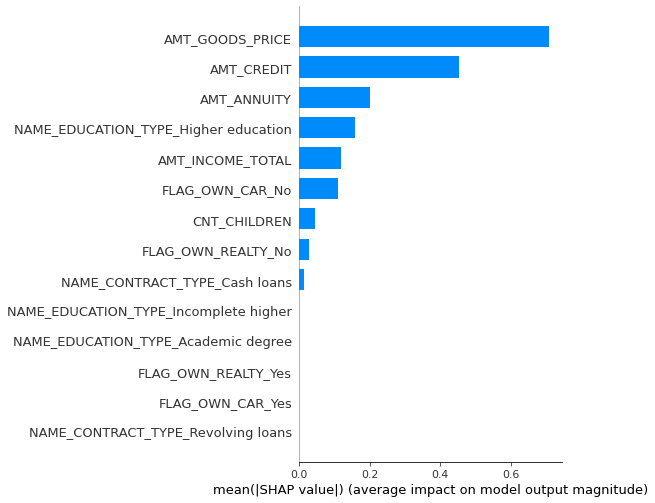

In [128]:
shap.summary_plot(shap_values, X_train, plot_type="bar",show=False)
plt.savefig('grafic.png')

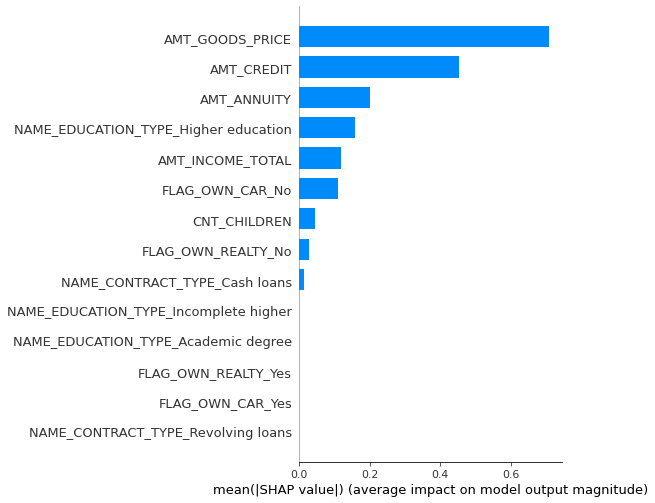

In [129]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

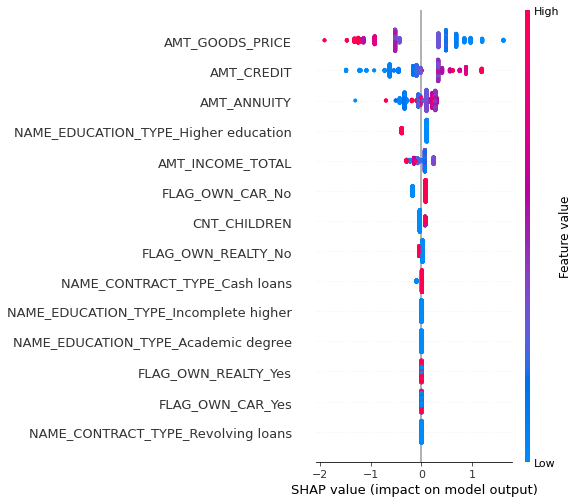

In [130]:
shap.summary_plot(shap_values, X_test)

In [131]:
row_to_show = 5

data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

XGB.predict_proba(data_for_prediction_array)

array([[0.28371823, 0.7162818 ]], dtype=float32)

Using 3877 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


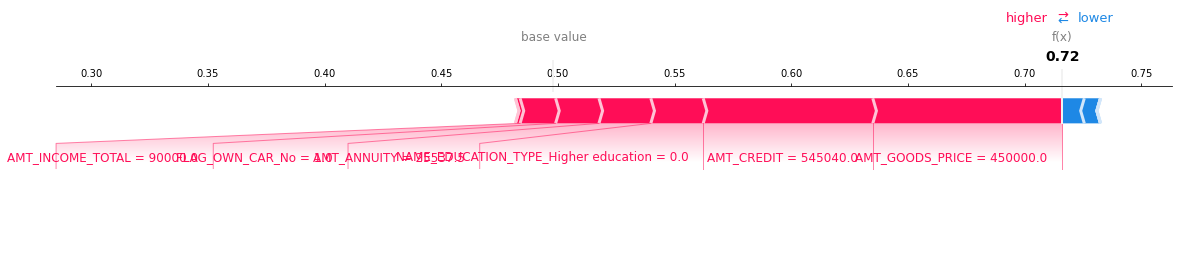

In [132]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(XGB.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction, matplotlib=True)

# Score

In [133]:
preds_proba = XGB.predict_proba(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [134]:
preds_proba

array([[0.4823106 , 0.5176894 ],
       [0.76132566, 0.23867434],
       [0.26555336, 0.73444664],
       ...,
       [0.54943496, 0.45056504],
       [0.5629186 , 0.4370814 ],
       [0.5429733 , 0.4570267 ]], dtype=float32)

In [135]:
df_preds_proba = pd.DataFrame(preds_proba, columns = ["0", "1"])
df_preds_proba

,0,1
0,0.482311,0.517689
1,0.761326,0.238674
2,0.265553,0.734447
3,0.455441,0.544559
4,0.219069,0.780931
5,0.283718,0.716282
6,0.536766,0.463234
7,0.642706,0.357294
8,0.534728,0.465272
9,0.502765,0.497235


In [136]:
 df_preds_proba["SK_ID_CURR"] = X_test_id["SK_ID_CURR"]

In [137]:
df_preds_proba

,0,1,SK_ID_CURR
0,0.482311,0.517689,323836
1,0.761326,0.238674,131938
2,0.265553,0.734447,251939
3,0.455441,0.544559,180549
4,0.219069,0.780931,326889
5,0.283718,0.716282,200764
6,0.536766,0.463234,136939
7,0.642706,0.357294,173879
8,0.534728,0.465272,438585
9,0.502765,0.497235,416045


In [138]:
df_preds_proba.to_csv(r"C:\/Users/ndergham/Desktop/OpenClassrooms/P7/data/proba.csv", index = False)